In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from src.utils import plot_accuracy_vs_metric
from src.metrics import (
    adaptive_calibration_error,
    weighted_average,
    brier_score,
    plot_calibration_curve)

In [2]:
graphics_format = ".png"
graphics_path = "/Users/christopher/Documents/University/Master/BEAR Confidence Estimation In LMs/Thesis/Graphics/"
tables_path = "/Users/christopher/Documents/University/Master/BEAR Confidence Estimation In LMs/Thesis/Tables/"
list_of_all_models = [x for x in os.listdir("../results/scores") if not x.startswith(".")]

# Experiment 2: Confidence Estimates Evaluation

### Long dataframe with instance-level predictions

In [3]:
instance_lvl_results = pd.read_json(
    "../results/instance_level_results.json",
    orient="records",
    lines=True
)

### Dataframe storing the estimators result per model for ACE and Brier Score

In [4]:
# For the correlation plot later
model_families = pd.DataFrame([
    ("bert-base-cased", "bert"),
    ("bert-large-cased", "bert"),
    ("gemma-2b", "gemma"),
    ("gemma-7b", "gemma"),
    ("gpt2", "gpt2"),
    ("gpt2-medium", "gpt2"),
    ("gpt2-large", "gpt2"),
    ("gpt2-xl", "gpt2"),
    ("opt-125m", "opt"),
    ("opt-350m", "opt"),
    ("opt-1.3b", "opt"),
    ("opt-6.7b", "opt"),
    ("roberta-base", "roberta"),
    ("roberta-large", "roberta"),
    ("xlm-roberta-base", "xlm-roberta"),
    ("xlm-roberta-large", "xlm-roberta")],
    columns=["model", "family"])

In [5]:
estimators = ["base_conf", "margin_conf", "average_conf_plurality", "consistency_conf_plurality", "weighted_conf"]
evaluation_metrics_per_model = {
    "model": [],
    "estimator": [],
    "accuracy": [],
    "ace": [],
    "brier_score": []
}
models = instance_lvl_results["model"].unique()

for model in models:
    df_model = instance_lvl_results[instance_lvl_results["model"] == model]

    for estimator in estimators:
        if estimator in ["average_conf_plurality", "consistency_conf_plurality"]:
            preds = df_model["plurality_correct"]
            evaluation_metrics_per_model["accuracy"].append(df_model["plurality_correct"].mean())
        elif estimator == "weighted_conf":
            preds = df_model["max_conf_correct"]
            evaluation_metrics_per_model["accuracy"].append(df_model["max_conf_correct"].mean())
        else:
            preds = df_model["correctly_predicted"]
            evaluation_metrics_per_model["accuracy"].append(df_model["correctly_predicted"].mean())

        confs = df_model[estimator]

        ace = adaptive_calibration_error(preds, confs, n_bins=20)
        brier = brier_score(preds, confs)
        evaluation_metrics_per_model["model"].append(model)
        evaluation_metrics_per_model["estimator"].append(estimator)
        evaluation_metrics_per_model["ace"].append(ace)
        evaluation_metrics_per_model["brier_score"].append(brier)
results_evaluation = pd.DataFrame(evaluation_metrics_per_model).merge(
    model_families,
    on="model",
    how="inner")

### Table 5.2: Adaptive Calibration Error of continously distributed estimators

In [6]:
(
    results_evaluation
    .pivot_table(index="model", columns="estimator", values="ace")
    .round(3)
    .reindex(columns=["base_conf", "margin_conf", "average_conf_plurality",
                      "consistency_conf_plurality", "weighted_conf"])
    .assign(row_min=lambda row: row.min(axis=1))
    .sort_values("row_min")
    .drop(columns="row_min")
    .to_latex(tables_path + "table_5_2.txt", float_format="%.3f", header=True)
)

### Table 5.3: Brier Score of the confidence estimates

In [7]:
(
    results_evaluation
    .pivot_table(index="model", columns="estimator", values="brier_score")
    .round(3)
    .reindex(columns=["base_conf", "margin_conf", "average_conf_plurality",
                      "consistency_conf_plurality", "weighted_conf"])
    .assign(row_min=lambda row: row.min(axis=1))
    .sort_values("row_min")
    .drop(columns="row_min")
    .to_latex(tables_path + "table_5_3.txt", float_format="%.3f", header=True)
)

### Figure 5.3: Calibration Curves for the smaller models

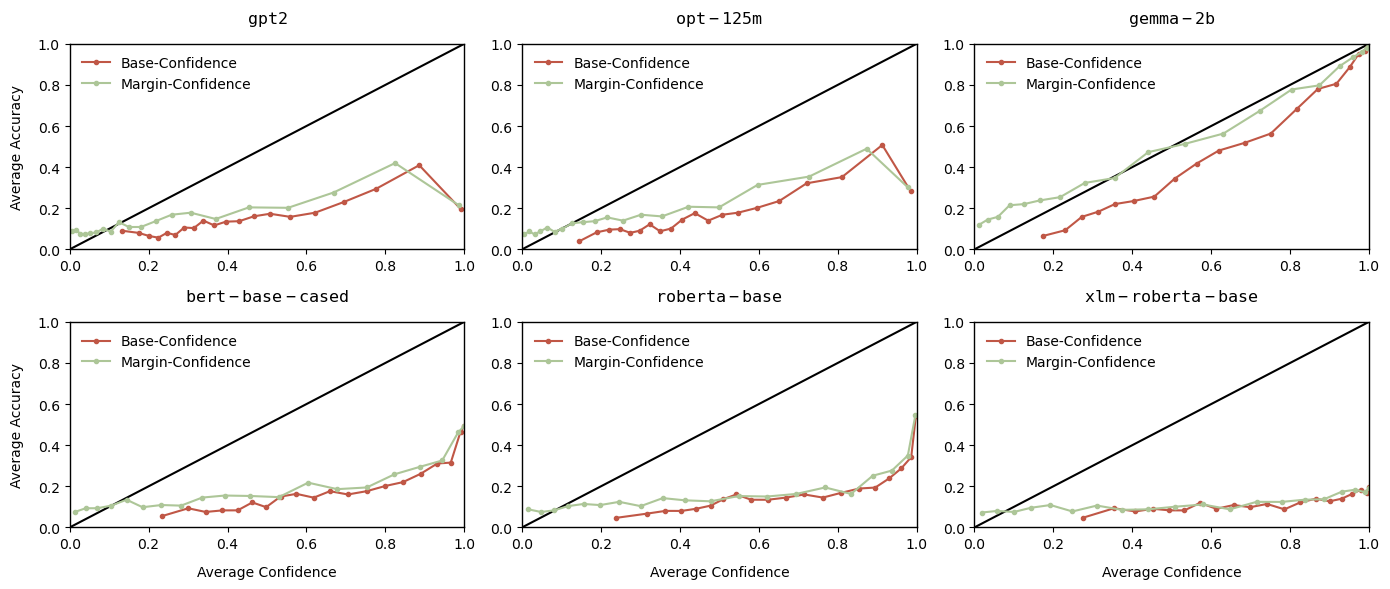

In [8]:
gemma_2b = instance_lvl_results[instance_lvl_results["model"] == "gemma-2b"]
gpt2 = instance_lvl_results[instance_lvl_results["model"] == "gpt2"]
opt125m = instance_lvl_results[instance_lvl_results["model"] == "opt-125m"]
bert_base = instance_lvl_results[instance_lvl_results["model"] == "bert-base-cased"]
roberta_base = instance_lvl_results[instance_lvl_results["model"] == "roberta-base"]
xlm_roberta_base = instance_lvl_results[instance_lvl_results["model"] == "xlm-roberta-base"]

models_info = [
    {
        "title": "gpt2",
        "df": gpt2,
        "pred_keys": ["correctly_predicted", "correctly_predicted"],
        "conf_keys": ["base_conf", "margin_conf"],
        "labels": ["Base-Confidence", "Margin-Confidence"],
        "row": 0, "col": 0
    },
    {
        "title": "opt-125m",
        "df": opt125m,
        "pred_keys": ["correctly_predicted", "correctly_predicted"],
        "conf_keys": ["base_conf", "margin_conf"],
        "labels": ["Base-Confidence", "Margin-Confidence"],
        "row": 0, "col": 1
    },
    {
        "title": "gemma-2b",
        "df": gemma_2b,
        "pred_keys": ["correctly_predicted", "correctly_predicted"],
        "conf_keys": ["base_conf", "margin_conf"],
        "labels": ["Base-Confidence", "Margin-Confidence"],
        "row": 0, "col": 2
    },
    {
        "title": "bert-base-cased",
        "df": bert_base,
        "pred_keys": ["correctly_predicted", "correctly_predicted"],
        "conf_keys": ["base_conf", "margin_conf"],
        "labels": ["Base-Confidence", "Margin-Confidence"],
        "row": 1, "col": 0
    },
    {
        "title": "roberta-base",
        "df": roberta_base,
        "pred_keys": ["correctly_predicted", "correctly_predicted"],
        "conf_keys": ["base_conf", "margin_conf"],
        "labels": ["Base-Confidence", "Margin-Confidence"],
        "row": 1, "col": 1
    },
    {
        "title": "xlm-roberta-base",
        "df": xlm_roberta_base,
        "pred_keys": ["correctly_predicted", "correctly_predicted"],
        "conf_keys": ["base_conf", "margin_conf"],
        "labels": ["Base-Confidence", "Margin-Confidence"],
        "row": 1, "col": 2
    },
]

_, axes = plt.subplots(2, 3, figsize=(14, 6), facecolor="white", sharey=True)

for info in models_info:
    ax = axes[info["row"], info["col"]]
    plot_calibration_curve(
        title=rf"$\mathtt{{{info['title']}}}$",
        predictions=[info["df"][k].tolist() for k in info["pred_keys"]],
        confidences=[info["df"][k].tolist() for k in info["conf_keys"]],
        labels=info["labels"],
        linestyles=["solid"]*2,
        markers=["."]*2,
        colors=["#c05746", "#adc698"],
        axis=ax
    )
    if info["col"] > 0:
        ax.set_ylabel("")
    if info["row"] == 0:
        ax.set_xlabel("")
plt.tight_layout()
plt.savefig(graphics_path + "calibration_curves_small_models" + graphics_format, dpi=600)
plt.show()

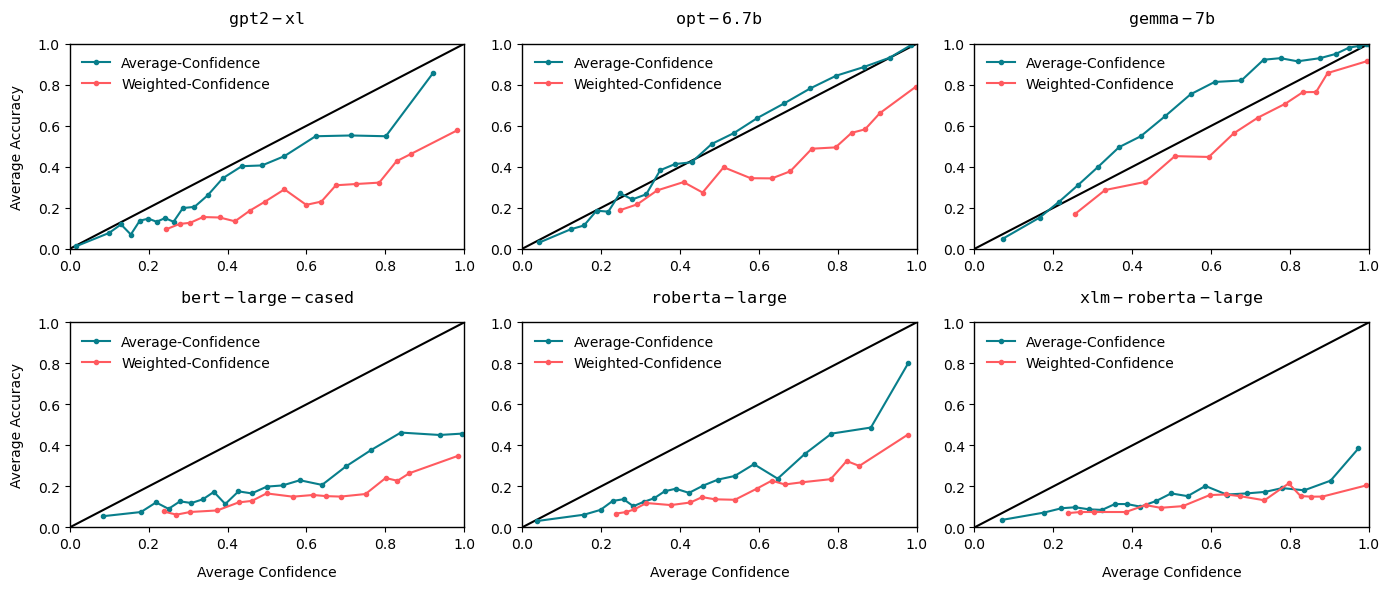

In [9]:
# Data for the larger models
gemma_7b = instance_lvl_results[instance_lvl_results["model"] == "gemma-7b"]
gpt2_xl = instance_lvl_results[instance_lvl_results["model"] == "gpt2-xl"]
opt67 = instance_lvl_results[instance_lvl_results["model"] == "opt-6.7b"]
bert_large = instance_lvl_results[instance_lvl_results["model"] == "bert-large-cased"]
roberta_large = instance_lvl_results[instance_lvl_results["model"] == "roberta-large"]
xlm_roberta_large = instance_lvl_results[instance_lvl_results["model"] == "xlm-roberta-large"]

models_info = [
    {
        "title": "gpt2-xl",
        "df": gpt2_xl,
        "pred_keys": ["plurality_correct", "max_conf_correct"],
        "conf_keys": ["average_conf_plurality", "weighted_conf"],
        "labels": ["Average-Confidence", "Weighted-Confidence"],
        "row": 0, "col": 0
    },
    {
        "title": "opt-6.7b",
        "df": opt67,
        "pred_keys": ["plurality_correct", "max_conf_correct"],
        "conf_keys": ["average_conf_plurality", "weighted_conf"],
        "labels": ["Average-Confidence", "Weighted-Confidence"],
        "row": 0, "col": 1
    },
    {
        "title": "gemma-7b",
        "df": gemma_7b,
        "pred_keys": ["plurality_correct", "max_conf_correct"],
        "conf_keys": ["average_conf_plurality", "weighted_conf"],
        "labels": ["Average-Confidence", "Weighted-Confidence"],
        "row": 0, "col": 2
    },
    {
        "title": "bert-large-cased",
        "df": bert_large,
        "pred_keys": ["plurality_correct", "max_conf_correct"],
        "conf_keys": ["average_conf_plurality", "weighted_conf"],
        "labels": ["Average-Confidence", "Weighted-Confidence"],
        "row": 1, "col": 0
    },
    {
        "title": "roberta-large",
        "df": roberta_large,
        "pred_keys": ["plurality_correct", "max_conf_correct"],
        "conf_keys": ["average_conf_plurality", "weighted_conf"],
        "labels": ["Average-Confidence", "Weighted-Confidence"],
        "row": 1, "col": 1
    },
    {
        "title": "xlm-roberta-large",
        "df": xlm_roberta_large,
        "pred_keys": ["plurality_correct", "max_conf_correct"],
        "conf_keys": ["average_conf_plurality", "weighted_conf"],
        "labels": ["Average-Confidence", "Weighted-Confidence"],
        "row": 1, "col": 2
    },
]

_, axes = plt.subplots(2, 3, figsize=(14, 6), facecolor="white", sharey=True)

for info in models_info:
    ax = axes[info["row"], info["col"]]
    plot_calibration_curve(
        title=rf"$\mathtt{{{info['title']}}}$",
        predictions=[info["df"][k].tolist() for k in info["pred_keys"]],
        confidences=[info["df"][k].tolist() for k in info["conf_keys"]],
        labels=info["labels"],
        linestyles=["solid"]*2,
        markers=["."]*2,
        colors=["#087e8b", "#ff5a5f"],
        axis=ax,
        n_bins=20
    )
    if info["col"] > 0:
        ax.set_ylabel("")
    if info["row"] == 0:
        ax.set_xlabel("")

plt.tight_layout()
plt.savefig(graphics_path + "calibration_curves_large_models" + graphics_format, dpi=600)
plt.show()

### Figure 5.5: Correlations between Accuracy and Adaptive Calibration Error

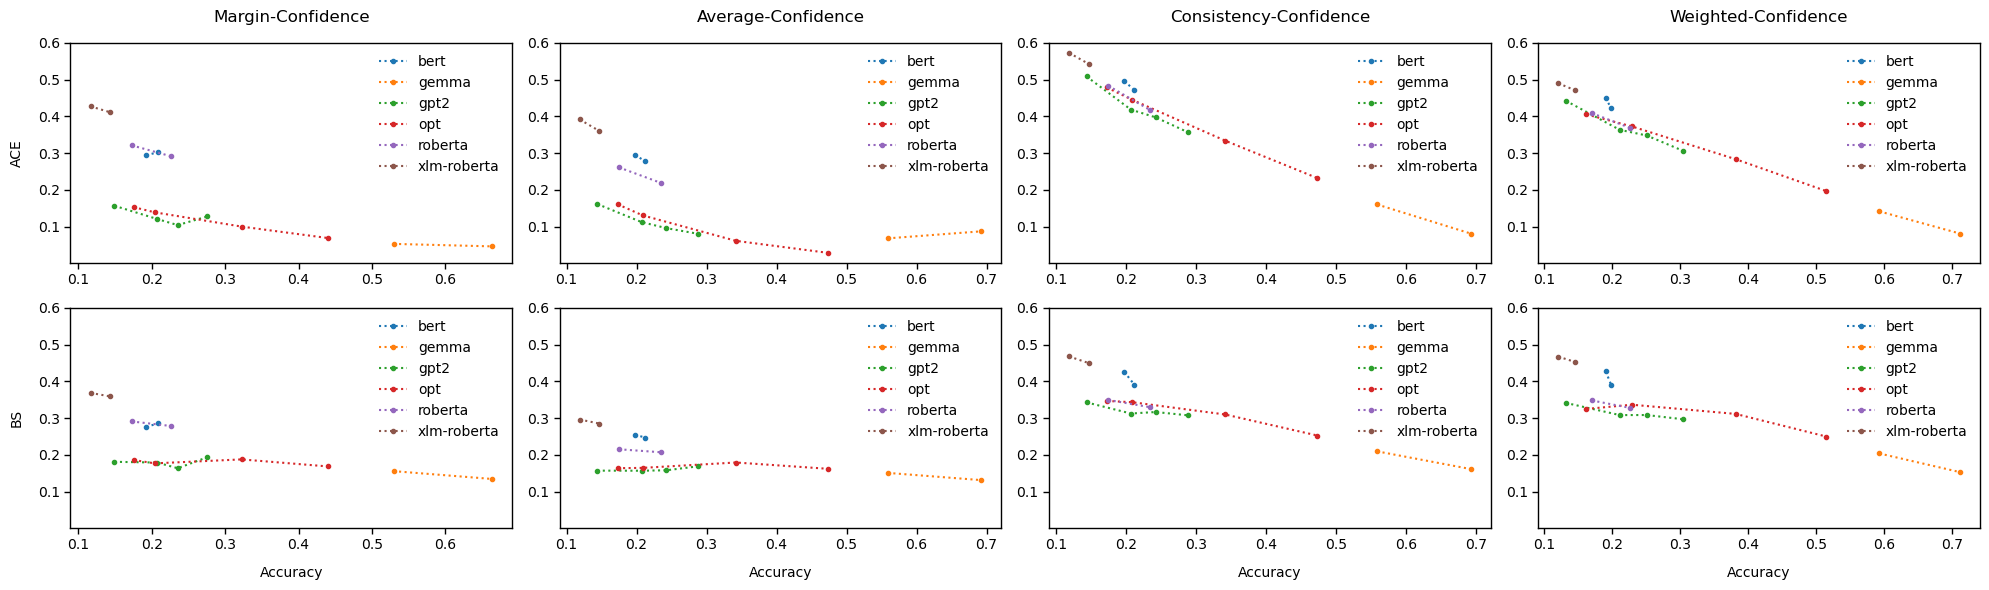

In [10]:
_, axes = plt.subplots(2, 4, figsize=(20, 6), facecolor="white", sharey=True)

plot_accuracy_vs_metric(results_evaluation, metric="ace", estimator="margin_conf",
                        title="Margin-Confidence", axis=axes[0,0])
axes[0,0].set_xlabel("")
axes[0,0].set_ylabel("ACE")
plot_accuracy_vs_metric(results_evaluation, metric="ace", estimator="average_conf_plurality",
                        title="Average-Confidence", axis=axes[0,1])
axes[0,1].set_xlabel("")
axes[0,1].set_ylabel("")
plot_accuracy_vs_metric(results_evaluation, metric="ace", estimator="consistency_conf_plurality",
                        title="Consistency-Confidence", axis=axes[0,2])
axes[0,2].set_xlabel("")
axes[0,2].set_ylabel("")
plot_accuracy_vs_metric(results_evaluation, metric="ace", estimator="weighted_conf",
                        title="Weighted-Confidence", axis=axes[0,3])
axes[0,3].set_xlabel("")
axes[0,3].set_ylabel("")

plot_accuracy_vs_metric(results_evaluation, metric="brier_score",
                        estimator="margin_conf", title="", axis=axes[1,0])
axes[1,0].set_ylabel("BS")
plot_accuracy_vs_metric(results_evaluation, metric="brier_score",
                        estimator="average_conf_plurality", title="", axis=axes[1,1])
axes[1,1].set_ylabel("")
plot_accuracy_vs_metric(results_evaluation, metric="brier_score",
                        estimator="consistency_conf_plurality", title="", axis=axes[1,2])
axes[1,2].set_ylabel("")
plot_accuracy_vs_metric(results_evaluation, metric="brier_score",
                        estimator="weighted_conf", title="", axis=axes[1,3])
axes[1,3].set_ylabel("")

plt.tight_layout()
plt.savefig(graphics_path + "acc_vs_metric" + graphics_format, dpi=600)
plt.show()

### Out-of-distribution detection.

In [11]:
# For each model we find the domain it performs worst in terms of BEAR score
r = {
    "model": [],
    "domain": [],
    "bear_score": []
}

for model in list_of_all_models:
    d = instance_lvl_results[instance_lvl_results["model"] == model].explode("domains")
    
    domain_scores = {}
    for domain in d["domains"].unique():
        domain_data = d[d["domains"] == domain]
        grouped = domain_data.groupby("relation").agg({
            "instance": "count",
            "bear_score": "mean",
        }).reset_index()

        domain_scores[domain] = weighted_average(grouped, "bear_score")

    lowest_domain = min(domain_scores, key=domain_scores.get)
    r["model"].append(model)
    r["domain"].append(lowest_domain)
    r["bear_score"].append(domain_scores[lowest_domain])

In [12]:
# For the respective domain, find estimator which performs best in terms of brier score and auroc
from sklearn.metrics import roc_auc_score
results_ood = {
    "model": [],
    "domain": [],
    "rejected": [],
    "bear_score": [],
    "estimator": [],
    "brier_score": [],
    "auroc": []
}
estimators = ["base_conf", "margin_conf", "average_conf_majority", "consistency_conf_majority", "weighted_conf"]

for model, domain, bear_score in zip(r["model"], r["domain"], r["bear_score"]):
    d = instance_lvl_results[instance_lvl_results["model"] == model].explode("domains")
    d = d[d["domains"] == domain]

    for estimator in estimators:
        if estimator in ["average_conf", "consistency_conf"]:
            preds = d["majority_correct"]
        elif estimator == "weighted_conf":
            preds = d["max_conf_correct"]
        else:
            preds = d["correctly_predicted"]
        confs = d[estimator]

        results_ood["model"].append(model)
        results_ood["domain"].append(domain)
        results_ood["rejected"].append(d["majority_fail"].sum()/len(d))
        results_ood["bear_score"].append(bear_score)
        results_ood["estimator"].append(estimator)
        results_ood["brier_score"].append(brier_score(preds, confs))
        results_ood["auroc"].append(roc_auc_score(preds, confs))

### Table 5.4: Best performing OOD detection method in terms of brier score.

In [13]:
(
    pd.DataFrame(results_ood)
    .round(3)
    .pipe(lambda row: row.loc[row.groupby("model")["brier_score"].idxmin()])
    .sort_values("brier_score")
    .to_latex(tables_path + "table_5_4.txt", float_format="%.3f", header=True, index=False)
)

In [14]:
(
    pd.DataFrame(results_ood)
    .round(3)
    .pipe(lambda row: row.loc[row.groupby("model")["brier_score"].idxmin()])
    .sort_values("brier_score")
)

,model,domain,rejected,bear_score,estimator,brier_score,auroc
7,opt-125m,Movies,0.403,0.084,average_conf_majority,0.097,0.648
67,gpt2,Movies,0.366,0.071,average_conf_majority,0.103,0.612
37,gemma-2b,Movies,0.377,0.408,average_conf_majority,0.114,0.908
62,gpt2-large,Movies,0.400,0.132,average_conf_majority,0.117,0.754
2,opt-350m,Movies,0.324,0.105,average_conf_majority,0.132,0.669
32,roberta-base,Movies,0.445,0.088,average_conf_majority,0.134,0.649
17,gpt2-medium,Movies,0.412,0.112,average_conf_majority,0.135,0.693
47,gpt2-xl,Movies,0.358,0.164,average_conf_majority,0.164,0.720
57,opt-1.3b,Movies,0.342,0.213,average_conf_majority,0.168,0.748
72,gemma-7b,Biographical,0.181,0.533,average_conf_majority,0.169,0.835
